<a href="https://colab.research.google.com/github/Veriny/MIT-6.S191/blob/master/tf2_0beta_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow==2.0.0-beta1

In [0]:
import tensorflow as tf

In [0]:
!pip install -q imageio


In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [0]:
def create_generator():
#   model = tf.keras.Sequential()
#   #We take in 100 samples at once?
#   krappa()
#   model.add(layers.Dense(7*7*256, use_bias=False, input_shape= (100,)))
#   #Now, we do batch normalization, which causes the data to become normally distributed with µ = 0 and stdev = 1. For why this is necessary: https://medium.com/deeper-learning/glossary-of-deep-learning-batch-normalisation-8266dcd2fa82
#   model.add(layers.BatchNormalization())
#   model.add(layers.LeakyReLU())
#   model.add(layers.Reshape((7, 7, 256)))
#   assert model.output_shape == (None, 7,7,256)
  
  
#   model.add(layers.Conv2DTranspose(128, (5,5), strides= (1,1), padding = 'same', use_bias = False))
#   assert model.output_shape == (None, 7, 7, 128)
#   model.add(layers.BatchNormalization())
#   model.add(layers.LeakyReLU())  
  
  
#   model.add(layers.Conv2DTranspose(64, (5,5), strides= (2,2), padding = 'same', use_bias = False))
#   assert model.output_shape == (None, 14, 14, 64)
#   model.add(layers.BatchNormalization())
#   model.add(layers.LeakyReLU())  

#   model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#   assert model.output_shape == (None, 28, 28, 1)
#   return model
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [0]:
generator = create_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

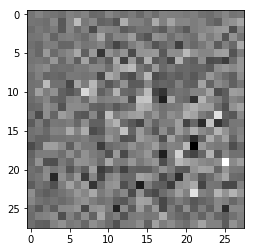

In [39]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [0]:
def create_discriminator():
  #sequential model with 2 Conv2D layers (w/ Leaky ReLu and 0.3 Dropout chance).
  #At the end we will flatten into a dense layer with a single neuron.
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                   input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [0]:
discriminator = create_discriminator()

In [0]:
result = discriminator(generated_image)

In [43]:
print(result)
#bruh moment

tf.Tensor([[-0.00339326]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
#define discriminator loss using helper functions
#From Tensorflow's docs: This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [0]:
#define generator loss
#From Tensorflow Docs: The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4
                                              )
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, dscriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
#From the tensorflow wiki: The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

@tf.function
def train_step(images):
  print('train step')
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    print("Pepega")
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  print("Dogchi")
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  print("Training")
  for epoch in range(epochs):
    print("Wew")
    start = time.time()

    for image_batch in dataset:
      print("Wowdess")
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

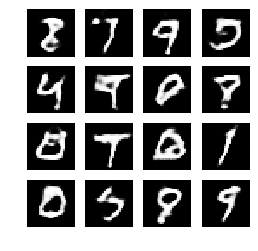

CPU times: user 2min 50s, sys: 42.8 s, total: 3min 33s
Wall time: 10min 27s


In [53]:
%%time
train(train_dataset, EPOCHS)

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

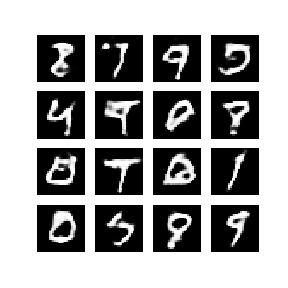

In [56]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)